# Grad-CAM for Nose Key Point Detection
This notebook applies Grad-CAM for key point detection on a specific region (like nose or eyes) using a pre-trained ResNet model.


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
import torch.nn.functional as F
from torchvision import models, transforms


### Load and preprocess the image

In [2]:
# Load the image
img = Image.open('D:\online class\DeepLearning\gradCAM\person_dog_horse.jpg')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

### Load the pre-trained ResNet model

In [3]:
# Load the model
resnet_model = models.resnet18(pretrained=True)
resnet_model.eval()

d:\online class\DeepLearning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\online class\DeepLearning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define Grad-CAM class

In [4]:
class GradCAM:
    def __init__(self, model, target_layer) -> None:
        self.model = model
        self.target_layer = target_layer
        self.activation_maps = None
        self.gradient_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, in_activation_maps, out_activation_maps):
            self.activation_maps = out_activation_maps

        def backward_hook(module, grad_in, grad_out):
            self.gradient_maps = grad_out[0]

        target_layer_module = dict(self.model.named_modules())[self.target_layer]
        target_layer_module.register_forward_hook(forward_hook)
        target_layer_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class_idx=None):
        output = self.model(input_tensor)
        if target_class_idx is None:
            class_idx = torch.argmax(output, dim=1)
        else:
            class_idx = target_class_idx
        self.model.zero_grad()
        target_class = output[:, class_idx]
        target_class.backward()
        weights = torch.mean(self.gradient_maps, dim=(2, 3))
        cam = torch.zeros(self.activation_maps.shape[2:], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            cam += w * self.activation_maps[0, i, :, :]
        cam = F.relu(cam)
        return (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0 and 1


### Generate the CAM and visualize the result

d:\online class\DeepLearning\venv\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


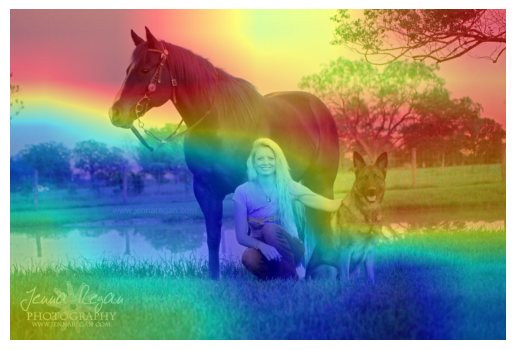

In [5]:
# Generate CAM for a specific class (e.g., 'dog' = 207)
grad_cam = GradCAM(resnet_model, 'layer4')
cam = grad_cam.generate_cam(input_tensor, target_class_idx=207)

# Convert the original image to numpy array and preprocess for overlay
orginal_img = np.array(img)
if orginal_img.ndim == 2:
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_GRAY2BGR)
else:
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_RGB2BGR)
orginal_img = np.float32(orginal_img) / 255

# Resize and apply the heatmap
cam = cam.detach().numpy()
cam = cv2.resize(cam, (orginal_img.shape[1], orginal_img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)

# Combine the heatmap with the original image
overlay = heatmap / 255 + orginal_img
overlay = overlay / np.max(overlay)  # Normalize overlay

# Display the result
plt.imshow(overlay)
plt.axis('off')
plt.show()
